In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve

from f_detrend import detrend_fuction

sn.set_style('whitegrid')
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [42]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,end_row='Total',
               endword=None,omit_list=['t20_21'],index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == end_row:
            break
        elif len(words)>1 and results_follow==1 and words[0] not in omit_list:
            row_names.append(words[0])
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))
    
    
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)
            
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table

In [3]:
dates = []
for year in range(1987,2023):
    for quarter in range(1,5):
        dates.append(str(year)+"Q"+str(quarter))
dates = dates[1:]

t0 = 59
T = len(dates)
date_dict = dict(zip(range(t0,T+t0),dates))
date_dict_reverse = dict(zip(dates,range(0,T)))
date_dict_reverse_ciclo = dict(zip(dates,range(t0,T+t0)))

## Original figure: 30-40 people, kids less than 10

In [4]:
path = './descriptive_stats/'
states = ['P','T','U','I','A']

stocks_mothers = read_table(path+'stocks_mothers_age3040_10_w.log',rescale=100)
stocks_mothers['dates'] = stocks_mothers.index.map(date_dict)
# Rescale
stocks_mothers['Total'] = stocks_mothers[states].sum(axis=1)
stocks_mothers['E'] = stocks_mothers['P'] + stocks_mothers['T']
for s in states+['E']:
    stocks_mothers[s] = stocks_mothers[s]/stocks_mothers['Total']

stocks_fathers = read_table(path+'stocks_fathers_age3040_10_w.log',rescale=100)
stocks_fathers['dates'] = stocks_fathers.index.map(date_dict)
# Rescale
stocks_fathers['Total'] = stocks_fathers[states].sum(axis=1)
stocks_fathers['E'] = stocks_fathers['P'] + stocks_fathers['T']
for s in states+['E']:
    stocks_fathers[s] = stocks_fathers[s]/stocks_fathers['Total']

In [5]:
states = ['P','T','U','I','A']
stocks_not_mothers = read_table(path+'stocks_not_mothers_age3040_w.log',rescale=100)
stocks_not_mothers['dates'] = stocks_not_mothers.index.map(date_dict)

# Rescale
stocks_not_mothers['Total'] = stocks_not_mothers[states].sum(axis=1)
stocks_not_mothers['E'] = stocks_not_mothers['P'] + stocks_not_mothers['T']
for s in states+['E']:
    stocks_not_mothers[s] = stocks_not_mothers[s]/stocks_not_mothers['Total']

stocks_not_fathers = read_table(path+'stocks_not_fathers_age3040_w.log',rescale=100)
stocks_not_fathers['dates'] = stocks_not_fathers.index.map(date_dict)
# Rescale
stocks_not_fathers['Total'] = stocks_not_fathers[states].sum(axis=1)
stocks_not_fathers['E'] = stocks_not_fathers['P'] + stocks_not_fathers['T']
for s in states+['E']:
    stocks_not_fathers[s] = stocks_not_fathers[s]/stocks_not_fathers['Total']

In [15]:
states = ['P','T','U','I','A']
stocks_single_women = read_table(path+'stocks_single_women_age3040_w.log',rescale=100)
stocks_single_women['dates'] = stocks_single_women.index.map(date_dict)

# Rescale
stocks_single_women['Total'] = stocks_single_women[states].sum(axis=1)
stocks_single_women['E'] = stocks_single_women['P'] + stocks_single_women['T']
for s in states+['E']:
    stocks_single_women[s] = stocks_single_women[s]/stocks_single_women['Total']

stocks_single_men = read_table(path+'stocks_single_men_age3040_w.log',rescale=100)
stocks_single_men['dates'] = stocks_single_men.index.map(date_dict)
# Rescale
stocks_single_men['Total'] = stocks_single_men[states].sum(axis=1)
stocks_single_men['E'] = stocks_single_men['P'] + stocks_single_men['T']
for s in states+['E']:
    stocks_single_men[s] = stocks_single_men[s]/stocks_single_men['Total']

In [6]:
# Export cell
for name, data in zip(['mothers_age3040_10_w','fathers_age3040_10_w','not_mothers_age3040_w','not_fathers_age3040_w'],
                        [stocks_mothers,stocks_fathers,stocks_not_mothers,stocks_not_fathers]):
    data.to_csv('./other_data/stocks/{}.csv'.format(name))

In [7]:
# Export cell
states = ['P','T','U','I','A']
for name in ['mothers_age3040_10','fathers_age3040_10','not_mothers_age3040','not_fathers_age3040']:
    data = read_table(path+'stocks_{}.log'.format(name),rescale=100)
    data['dates'] = data.index.map(date_dict)

    # Rescale
    data['Total'] = data[states].sum(axis=1)
    data['E'] = data['P'] + data['T']
    for s in states+['E']:
        data[s] = data[s]/data['Total']
    data.to_csv('./other_data/stocks/{}.csv'.format(name))

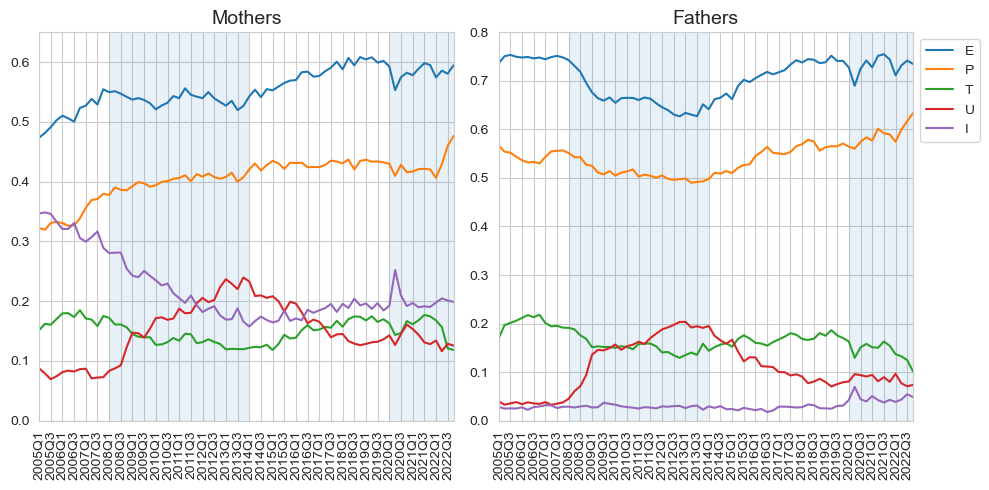

In [8]:
t0 = '2013Q4'
states = ['E','P','T','U','I']
colors = sn.color_palette()
T = stocks_mothers['dates'].size-1
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('Mothers',fontsize=14)
for s,c in zip(states,colors):
    plt.plot(stocks_mothers['dates'],stocks_mothers[s],c=c,label=s)
    
plt.axvspan('2008Q1','2014Q1', color=colors[0], alpha=0.1, lw=0)
plt.axvspan('2020Q1','2022Q4', color=colors[0], alpha=0.1, lw=0)

plt.xticks(stocks_fathers['dates'][::2],rotation=90)
plt.xlim(0,T)
plt.ylim(0,0.65)
# plt.legend(ncol=5,bbox_to_anchor=(0.7,-0.2))

plt.subplot(122)
plt.title('Fathers',fontsize=14)
for s,c in zip(states,colors):
    plt.plot(stocks_fathers['dates'],stocks_fathers[s],c=c,label=s)
    
plt.axvspan('2008Q1','2014Q1', color=colors[0], alpha=0.1, lw=0)
plt.axvspan('2020Q1','2022Q4', color=colors[0], alpha=0.1, lw=0)

plt.xticks(stocks_fathers['dates'][::2],rotation=90)
plt.xlim(0,T)
plt.ylim(0,0.8)
plt.legend(bbox_to_anchor=(1,1))

plt.tight_layout()
#plt.savefig('./plots/stocks_spain_parents.pdf',format='pdf',bbox_inches='tight') #,pil_kwargs={'quality':95}
plt.show()

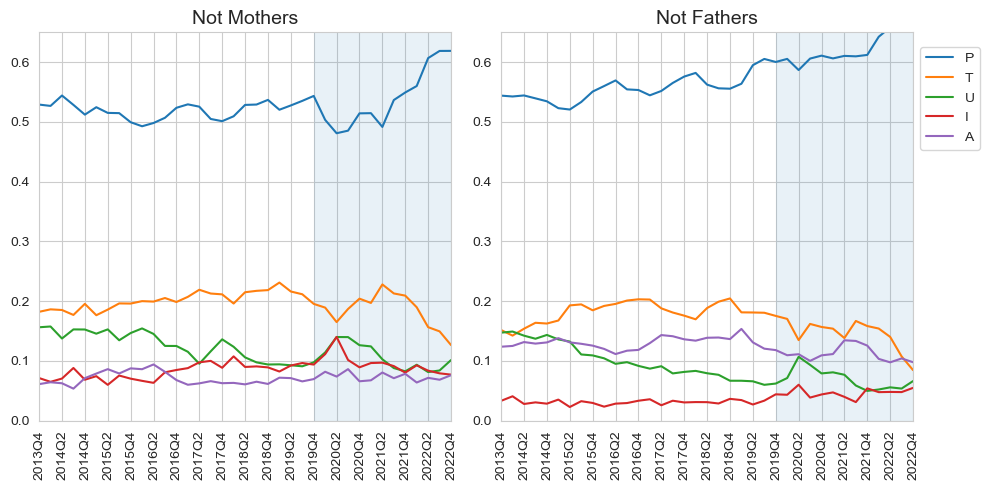

In [9]:
t0 = date_dict_reverse_ciclo['2013Q4']
t00 = date_dict_reverse_ciclo['2019Q4']-t0
T=  date_dict_reverse_ciclo['2022Q4']-t0

states = ['P','T','U','I','A']
colors = sn.color_palette()
T = stocks_not_mothers['dates'].loc[t0:].size-1
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('Not Mothers',fontsize=14)
for s,c in zip(states,colors):
    plt.plot(stocks_not_mothers['dates'].loc[t0:],stocks_not_mothers[s].loc[t0:],c=c,label=s)
    
#plt.axvspan('2008Q1','2014Q1', color=colors[0], alpha=0.1, lw=0)
plt.axvspan(t00,T, color=colors[0], alpha=0.1, lw=0)

plt.xticks(stocks_not_fathers['dates'].loc[t0::2],rotation=90)
plt.xlim(0,T)
plt.ylim(0,0.65)
# plt.legend(ncol=5,bbox_to_anchor=(0.7,-0.2))

plt.subplot(122)
plt.title('Not Fathers',fontsize=14)
for s,c in zip(states,colors):
    plt.plot(stocks_not_fathers['dates'].loc[t0:],stocks_not_fathers[s].loc[t0:],c=c,label=s)
    
#plt.axvspan('2013Q1','2014Q1', color=colors[0], alpha=0.1, lw=0)
plt.axvspan(t00,T, color=colors[0], alpha=0.1, lw=0)

plt.xticks(stocks_not_fathers['dates'].loc[t0::2],rotation=90)
plt.xlim(0,T)
plt.ylim(0,0.65)
plt.legend(bbox_to_anchor=(1,0.98))

plt.tight_layout()
#plt.savefig('./plots/stocks_spain_nonparents.pdf',format='pdf',bbox_inches='tight') #,pil_kwargs={'quality':95}
plt.show()

In [16]:
date_cuts_20_m = np.vstack((['2014Q1',],['2022Q4',]))
t0 = date_dict_reverse_ciclo[date_cuts_20_m[0].item()]
states = ['E','P','T','U','I']

stocks_mothers_detrend, stocks_mothers_detrend_up, stocks_mothers_detrend_down = {}, {}, {}
stocks_fathers_detrend, stocks_fathers_detrend_up, stocks_fathers_detrend_down = {}, {}, {}
for st in states:
    trend, predict, predict_up, predict_down = detrend_fuction(stocks_mothers,st,date_cuts_20_m,
                                                 date0='2019Q4',dateT='2022Q4',date_dict=date_dict_reverse_ciclo,extended=True)
    stocks_mothers_detrend[st] = stocks_mothers[st].loc[t0:] - predict
    stocks_mothers_detrend_up[st] = stocks_mothers[st].loc[t0:] - predict_up
    stocks_mothers_detrend_down[st] = stocks_mothers[st].loc[t0:] - predict_down
    
    trend, predict, predict_up, predict_down = detrend_fuction(stocks_fathers,st,date_cuts_20_m,
                                                 date0='2019Q4',dateT='2022Q4',date_dict=date_dict_reverse_ciclo,extended=True)
    stocks_fathers_detrend[st] = stocks_fathers[st].loc[t0:] - predict
    stocks_fathers_detrend_up[st] = stocks_fathers[st].loc[t0:] - predict_up
    stocks_fathers_detrend_down[st] = stocks_fathers[st].loc[t0:] - predict_down
    
stocks_not_mothers_detrend, stocks_not_mothers_detrend_up, stocks_not_mothers_detrend_down = {}, {}, {}
stocks_not_fathers_detrend, stocks_not_fathers_detrend_up, stocks_not_fathers_detrend_down = {}, {}, {}
for st in states:
    trend, predict, predict_up, predict_down = detrend_fuction(stocks_not_mothers,st,date_cuts_20_m,
                                                 date0='2019Q4',dateT='2022Q4',date_dict=date_dict_reverse_ciclo,extended=True)
    stocks_not_mothers_detrend[st] = stocks_not_mothers[st].loc[t0:] - predict
    stocks_not_mothers_detrend_up[st] = stocks_not_mothers[st].loc[t0:] - predict_up
    stocks_not_mothers_detrend_down[st] = stocks_not_mothers[st].loc[t0:] - predict_down
    
    trend, predict, predict_up, predict_down = detrend_fuction(stocks_not_fathers,st,date_cuts_20_m,
                                                 date0='2019Q4',dateT='2022Q4',date_dict=date_dict_reverse_ciclo,extended=True)
    stocks_not_fathers_detrend[st] = stocks_not_fathers[st].loc[t0:] - predict
    stocks_not_fathers_detrend_up[st] = stocks_not_fathers[st].loc[t0:] - predict_up
    stocks_not_fathers_detrend_down[st] = stocks_not_fathers[st].loc[t0:] - predict_down

In [18]:
date_cuts_20_m = np.vstack((['2014Q1',],['2022Q4',]))
t0 = date_dict_reverse_ciclo[date_cuts_20_m[0].item()]
states = ['E','P','T','U','I']
    
stocks_single_women_detrend, stocks_single_women_detrend_up, stocks_single_women_detrend_down = {}, {}, {}
stocks_single_men_detrend, stocks_single_men_detrend_up, stocks_single_men_detrend_down = {}, {}, {}
for st in states:
    trend, predict, predict_up, predict_down = detrend_fuction(stocks_single_women,st,date_cuts_20_m,
                                                 date0='2019Q4',dateT='2022Q4',date_dict=date_dict_reverse_ciclo,extended=True)
    stocks_single_women_detrend[st] = stocks_single_women[st].loc[t0:] - predict
    stocks_single_women_detrend_up[st] = stocks_single_women[st].loc[t0:] - predict_up
    stocks_single_women_detrend_down[st] = stocks_single_women[st].loc[t0:] - predict_down
    
    trend, predict, predict_up, predict_down = detrend_fuction(stocks_single_men,st,date_cuts_20_m,
                                                 date0='2019Q4',dateT='2022Q4',date_dict=date_dict_reverse_ciclo,extended=True)
    stocks_single_men_detrend[st] = stocks_single_men[st].loc[t0:] - predict
    stocks_single_men_detrend_up[st] = stocks_single_men[st].loc[t0:] - predict_up
    stocks_single_men_detrend_down[st] = stocks_single_men[st].loc[t0:] - predict_down

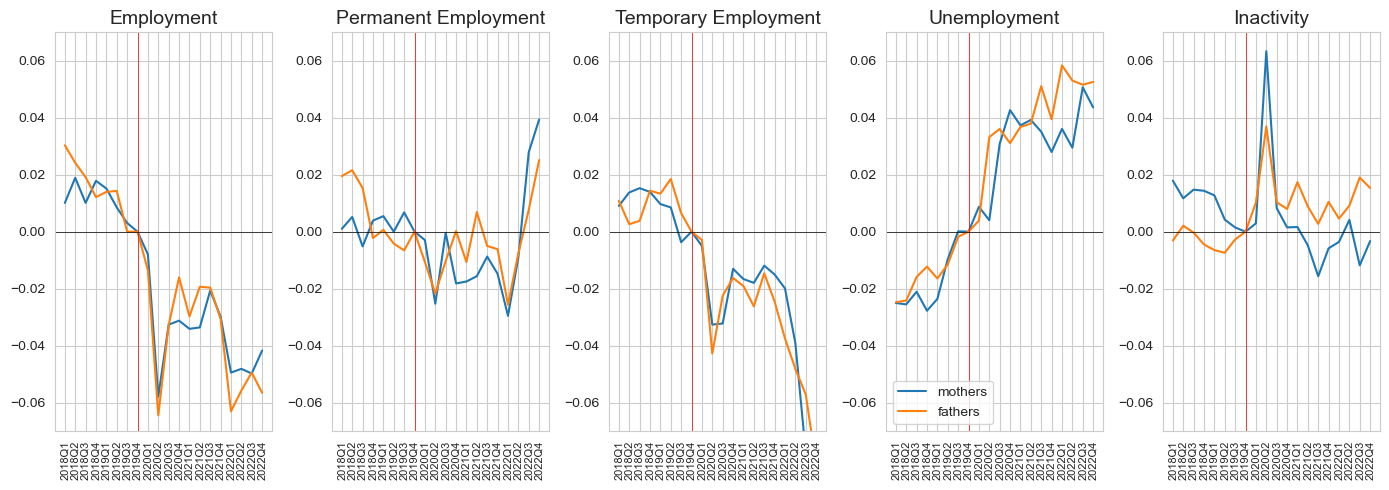

In [29]:
t0 = date_dict_reverse_ciclo['2018Q1']
t19 = date_dict_reverse_ciclo['2019Q4']
t00 = t0 - date_dict_reverse_ciclo['2016Q1']
T = date_dict_reverse_ciclo['2021Q4']-t0
dt_boom = T - (date_dict_reverse_ciclo['2021Q4']-date_dict_reverse_ciclo['2019Q4'])
dt_bot = T - (date_dict_reverse_ciclo['2021Q4']-date_dict_reverse_ciclo['2020Q2'])
colors = sn.color_palette()

labels = ['Employment','Permanent Employment','Temporary Employment','Unemployment','Inactivity'] #,'Self-Employment'
labels_st = ['Mothers','Fathers']
# lims = [(-120000,60000),(-60000,140000),(-175000,25000),(-25000,150000)]

plt.figure(figsize=(14,5))
    
for j,s in enumerate(states):
    plt.subplot(1,5,(j+1))
    plt.title(labels[j],fontsize=14)
    plt.plot(stocks_mothers['dates'].loc[t0:],
             stocks_mothers_detrend[s].loc[t0:]-stocks_mothers_detrend[s].loc[t19],label='mothers')
    plt.plot(stocks_fathers['dates'].loc[t0:],
             stocks_fathers_detrend[s].loc[t0:]-stocks_fathers_detrend[s].loc[t19],label='fathers')

    plt.ylim(-0.07,0.07)
    plt.xticks(rotation=90,fontsize=8)
    plt.axvline(dt_boom,c='r',lw=0.5)
    plt.axhline(c='k',lw=0.5)
    if j==3:
        plt.legend(loc='lower left')

plt.tight_layout()
#plt.savefig('./plots/spain_stocks_detrend_mothersVsfathers.pdf',format='pdf',bbox_inches='tight')
plt.show()

### Each sex separately

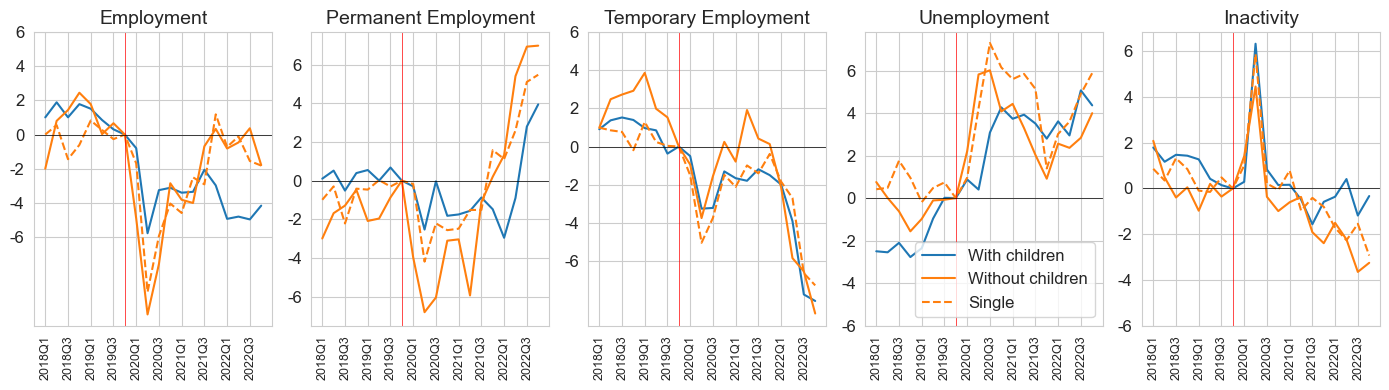

In [25]:
t0 = date_dict_reverse_ciclo['2018Q1']
t19 = date_dict_reverse_ciclo['2019Q4']
t00 = t0 - date_dict_reverse_ciclo['2016Q1']
T = date_dict_reverse_ciclo['2021Q4']-t0
dt_boom = T - (date_dict_reverse_ciclo['2021Q4']-date_dict_reverse_ciclo['2019Q4'])
dt_bot = T - (date_dict_reverse_ciclo['2021Q4']-date_dict_reverse_ciclo['2020Q2'])
colors = sn.color_palette()

labels = ['Employment','Permanent Employment','Temporary Employment','Unemployment','Inactivity','Self-Employment']
labels_st = ['Mothers','Fathers']
# lims = [(-120000,60000),(-60000,140000),(-175000,25000),(-25000,150000)]

plt.figure(figsize=(14,4))
    
for j,s in enumerate(states):
    plt.subplot(1,5,(j+1))
    plt.title(labels[j],fontsize=14)
    dev_trend_moms = stocks_mothers_detrend[s].loc[t0:]-stocks_mothers_detrend[s].loc[t19]
    dev_trend_moms_up = stocks_mothers_detrend_up[s].loc[t0:]-stocks_mothers_detrend_up[s].loc[t19]
    dev_trend_moms_down = stocks_mothers_detrend_down[s].loc[t0:]-stocks_mothers_detrend_down[s].loc[t19]
    
    plt.plot(stocks_mothers['dates'].loc[t0:],dev_trend_moms,label='With children',c=colors[0])
#     plt.fill_between(stocks_mothers['dates'].loc[t0:],dev_trend_moms,dev_trend_moms_up, color=colors[0], alpha=0.5, lw=0)
#     plt.fill_between(stocks_mothers['dates'].loc[t0:],dev_trend_moms,dev_trend_moms_down, color=colors[0], alpha=0.5, lw=0)
    #plt.plot(,label='mothers',c=colors[0])
    
    dev_trend_0k = stocks_not_mothers_detrend[s].loc[t0:]-stocks_not_mothers_detrend[s].loc[t19]
    dev_trend_0k_up = stocks_not_mothers_detrend_up[s].loc[t0:]-stocks_not_mothers_detrend_up[s].loc[t19]
    dev_trend_0k_down = stocks_not_mothers_detrend_down[s].loc[t0:]-stocks_not_mothers_detrend_down[s].loc[t19]
    
    plt.plot(stocks_not_mothers['dates'].loc[t0:],dev_trend_0k,label='Without children',c=colors[1])
#     plt.fill_between(stocks_not_mothers['dates'].loc[t0:],dev_trend_0k,dev_trend_0k_up, color=colors[1], alpha=0.5, lw=0)
#     plt.fill_between(stocks_not_mothers['dates'].loc[t0:],dev_trend_0k,dev_trend_0k_down, color=colors[1], alpha=0.5, lw=0)
    
    dev_trend_s = stocks_single_women_detrend[s].loc[t0:]-stocks_single_women_detrend[s].loc[t19]
    plt.plot(stocks_single_women['dates'].loc[t0:],dev_trend_s,label='Single',c=colors[1],ls='--')
    
    plt.yticks(np.arange(-0.06,0.07,0.02),np.arange(-6,8,2),fontsize=12)
    plt.xticks(stocks_single_women['dates'].loc[t0::2],rotation=90,fontsize=9)
    plt.axvline(dt_boom,c='r',lw=0.5)
    plt.axhline(c='k',lw=0.5)
    if j==3:
        plt.legend(loc='lower right',fontsize=12)

plt.tight_layout()
# plt.savefig('./plots_stocks/spain_stocks_detrend_mothers_extended.pdf',format='pdf',bbox_inches='tight')
plt.show()

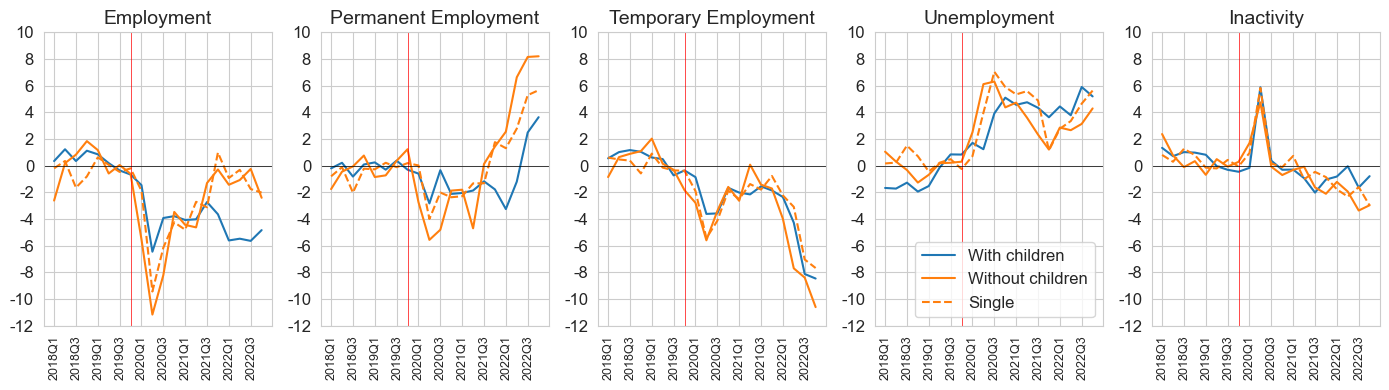

In [28]:
t0 = date_dict_reverse_ciclo['2018Q1']
t19 = date_dict_reverse_ciclo['2019Q1']
t20 = date_dict_reverse_ciclo['2019Q4']
t00 = t0 - date_dict_reverse_ciclo['2016Q1']
T = date_dict_reverse_ciclo['2021Q4']-t0
dt_boom = T - (date_dict_reverse_ciclo['2021Q4']-date_dict_reverse_ciclo['2019Q4'])
dt_bot = T - (date_dict_reverse_ciclo['2021Q4']-date_dict_reverse_ciclo['2020Q2'])
colors = sn.color_palette()

labels = ['Employment','Permanent Employment','Temporary Employment','Unemployment','Inactivity','Self-Employment']
labels_st = ['Mothers','Fathers']
# lims = [(-120000,60000),(-60000,140000),(-175000,25000),(-25000,150000)]

plt.figure(figsize=(14,4))
    
for j,s in enumerate(states):
    plt.subplot(1,5,(j+1))
    plt.title(labels[j],fontsize=14)
    
    dev_trend_moms = stocks_mothers_detrend[s].loc[t0:]-np.average(stocks_mothers_detrend[s].loc[t19:t20])    
    plt.plot(stocks_mothers['dates'].loc[t0:],dev_trend_moms,label='With children',c=colors[0])
    
    dev_trend_0k = stocks_not_mothers_detrend[s].loc[t0:]-np.average(stocks_not_mothers_detrend[s].loc[t19:t20]) 
    plt.plot(stocks_not_mothers['dates'].loc[t0:],dev_trend_0k,label='Without children',c=colors[1])
    
    dev_trend_s = stocks_single_women_detrend[s].loc[t0:]-np.average(stocks_single_women_detrend[s].loc[t19:t20]) 
    plt.plot(stocks_single_women['dates'].loc[t0:],dev_trend_s,label='Single',c=colors[1],ls='--')
    
    plt.yticks(np.arange(-0.12,0.12,0.02),np.arange(-12,12,2),fontsize=12)
    plt.xticks(stocks_single_women['dates'].loc[t0::2],rotation=90,fontsize=9)
    plt.axvline(dt_boom,c='r',lw=0.5)
    plt.axhline(c='k',lw=0.5)
    if j==3:
        plt.legend(loc='lower right',fontsize=12)

plt.tight_layout()
# plt.savefig('./plots_stocks/spain_stocks_detrend_mothers_extended.pdf',format='pdf',bbox_inches='tight')
plt.show()

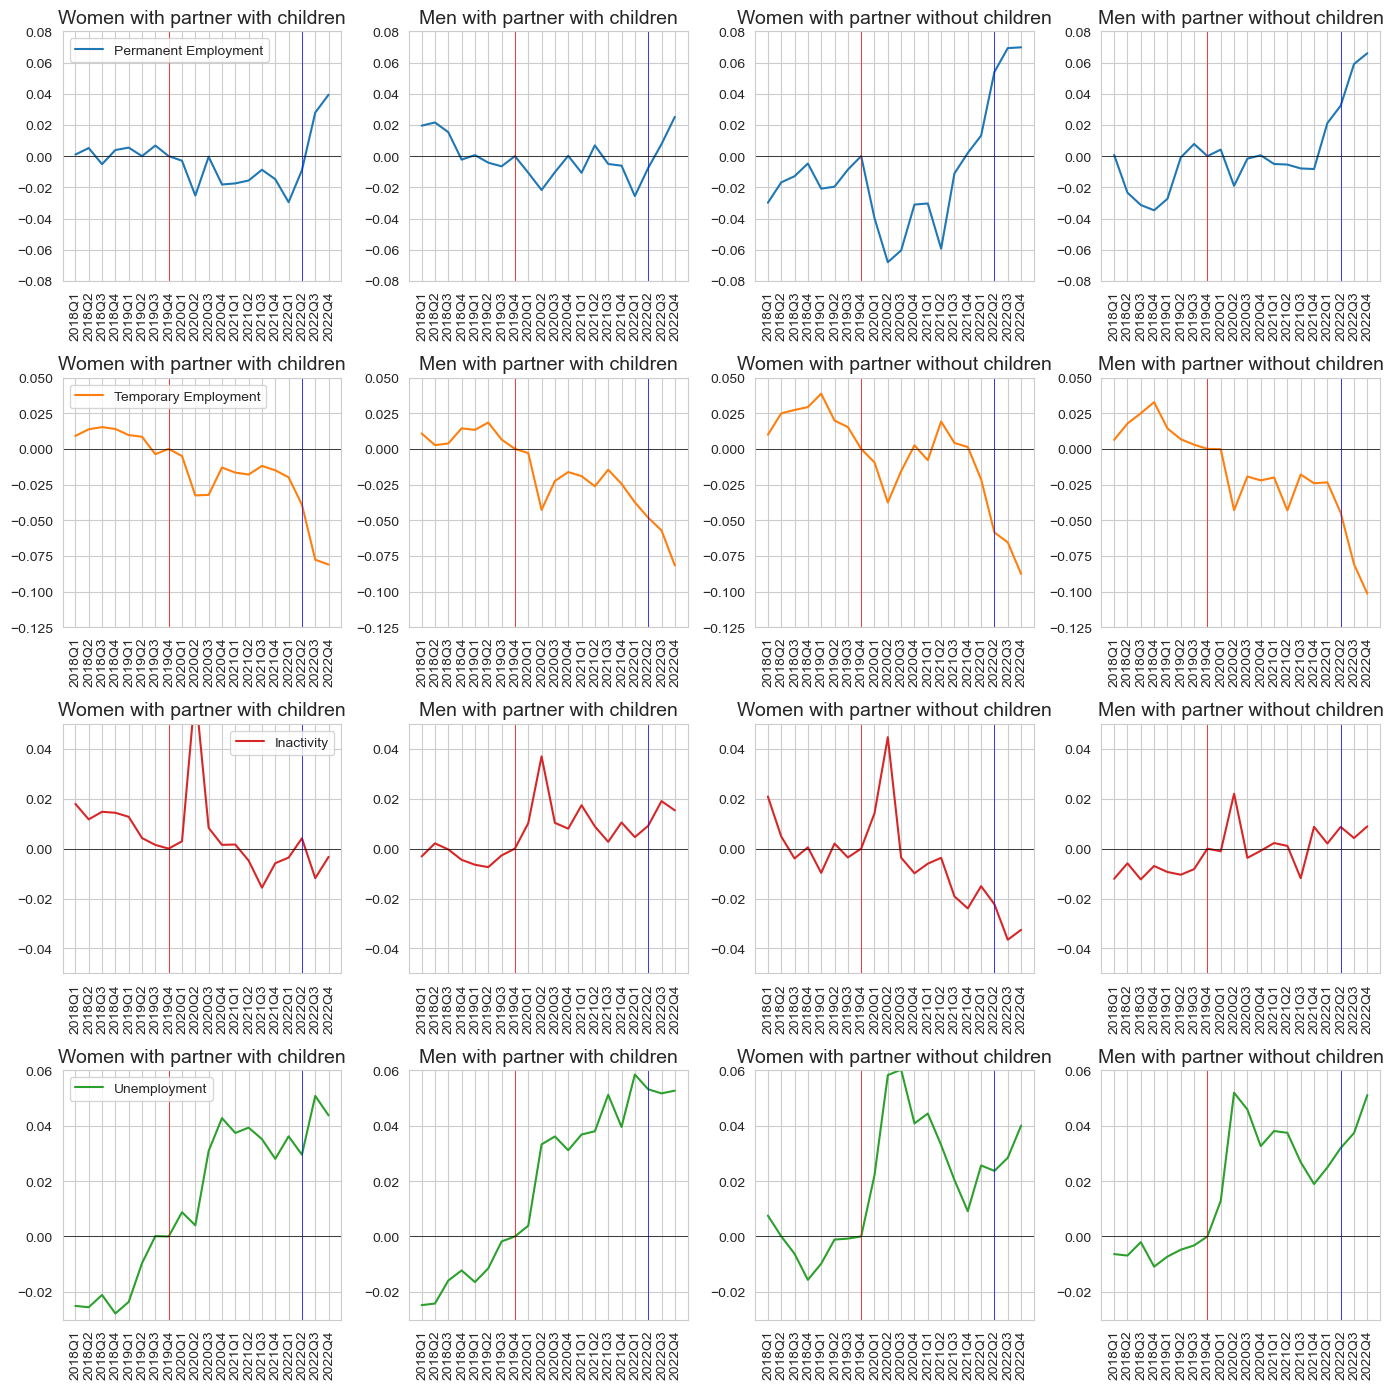

In [35]:
t0 = date_dict_reverse_ciclo['2018Q1']
t00 = t0 - date_dict_reverse_ciclo['2016Q1']
T = date_dict_reverse_ciclo['2021Q1']-t0
dt_boom = T - (date_dict_reverse_ciclo['2021Q1']-date_dict_reverse_ciclo['2019Q4'])
dt_bot = T - (date_dict_reverse_ciclo['2021Q1']-date_dict_reverse_ciclo['2020Q2'])

dt_reform = T - (date_dict_reverse_ciclo['2021Q1']-date_dict_reverse_ciclo['2022Q2'])

states = ['P','T','I',"U"]
series = [stocks_mothers_detrend,stocks_fathers_detrend,stocks_not_mothers_detrend,stocks_not_fathers_detrend]

color_dict = dict(zip(['P','T',"U",'I',"A"],sn.color_palette()[:5]))
labels = ['Permanent Employment','Temporary Employment','Inactivity','Unemployment']
labels_st = ['Women with partner with children','Men with partner with children',
             'Women with partner without children','Men with partner without children']

lims = [(-0.08,0.08),(-0.125,0.05),(-0.05,0.05),(-0.03,0.06)]
plt.figure(figsize=(14,14))

for j,s in enumerate(states):
    for i,ser in enumerate(series):
        plt.subplot(4,4,(i+1)+j*4)
        plt.title(labels_st[i],fontsize=14)
        plt.plot(stocks_mothers['dates'].loc[t0:],ser[s].loc[t0:]-ser[s].loc[t19],
                 label=labels[j],c=color_dict[s])

        plt.ylim(lims[j])
        plt.xticks(rotation=90)
        if i==0:
            plt.legend()
        plt.axvline(dt_boom,c='r',lw=0.5)
        plt.axvline(dt_reform,c='b',lw=0.5)
        plt.axhline(c='k',lw=0.5)

plt.tight_layout()
# plt.savefig('./plots_stocks/spain_stocks_detrend_partner.pdf',format='pdf',bbox_inches='tight')
plt.show()

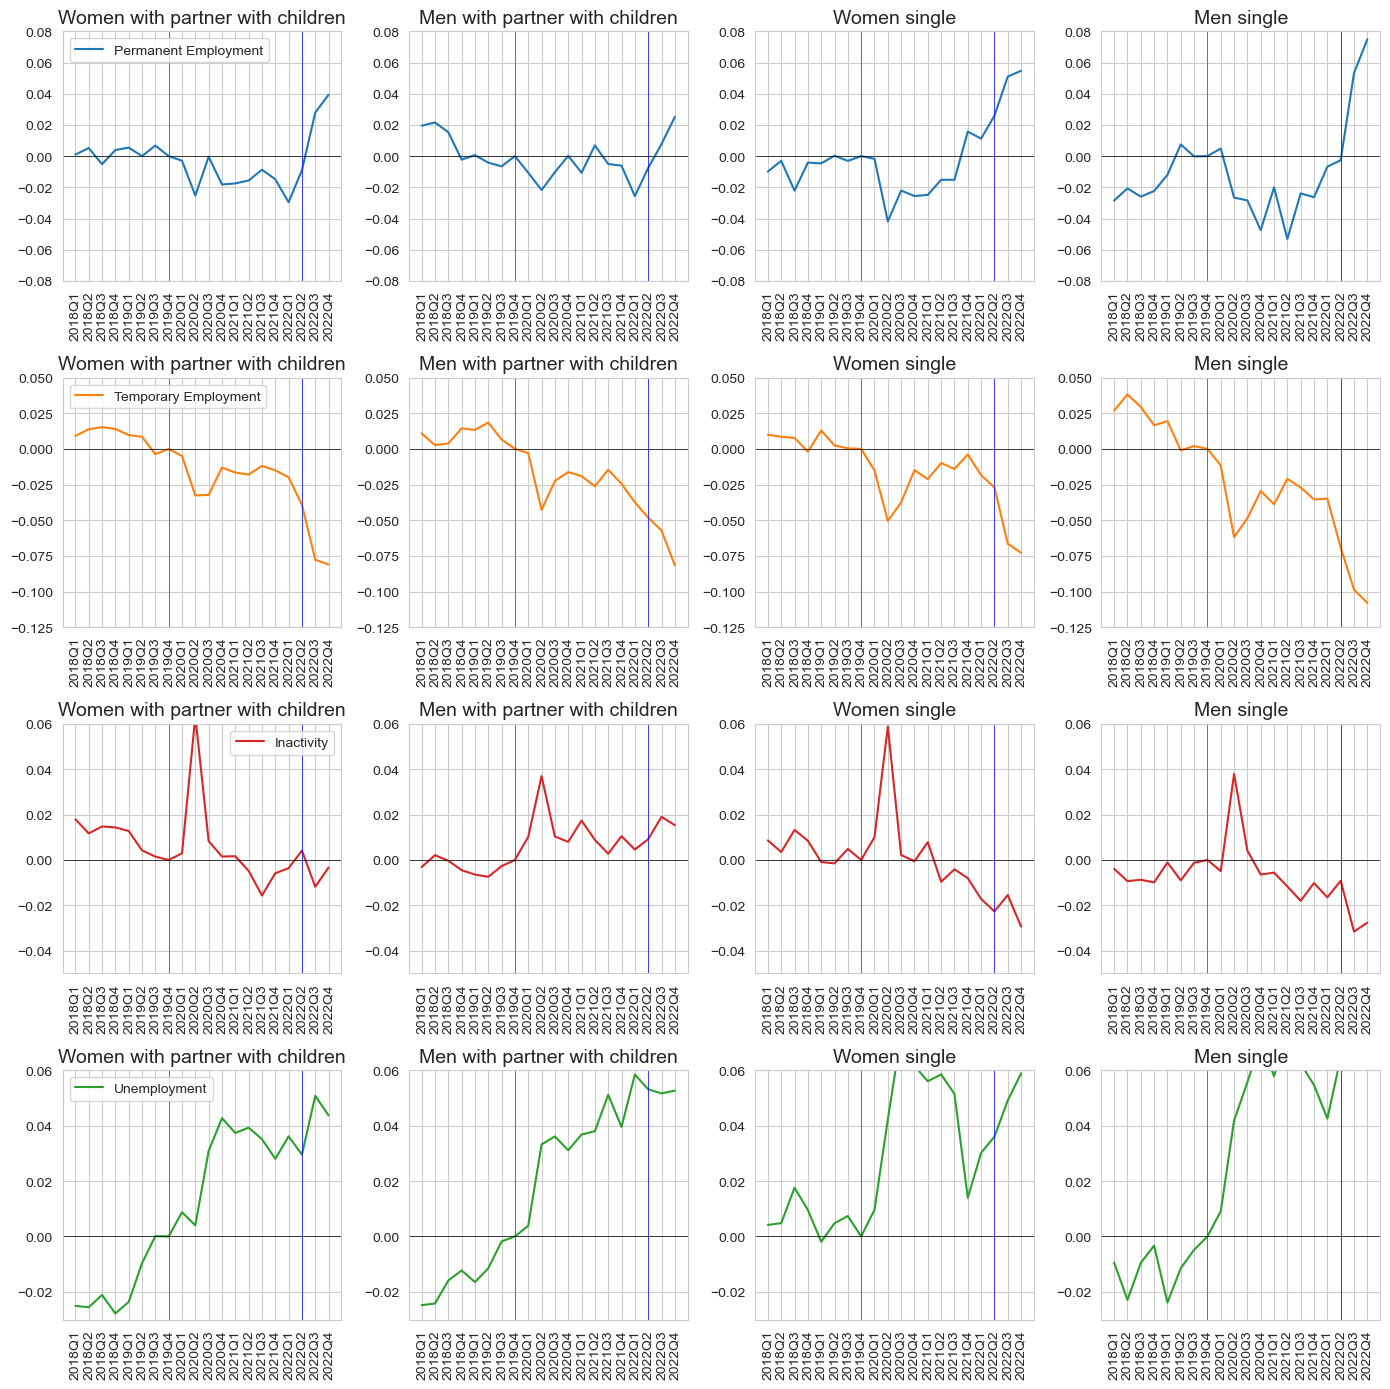

In [37]:
t0 = date_dict_reverse_ciclo['2018Q1']
t00 = t0 - date_dict_reverse_ciclo['2016Q1']
T = date_dict_reverse_ciclo['2021Q1']-t0
dt_boom = T - (date_dict_reverse_ciclo['2021Q1']-date_dict_reverse_ciclo['2019Q4'])
dt_bot = T - (date_dict_reverse_ciclo['2021Q1']-date_dict_reverse_ciclo['2020Q2'])

dt_reform = T - (date_dict_reverse_ciclo['2021Q1']-date_dict_reverse_ciclo['2022Q2'])

states = ['P','T','I',"U"]
series = [stocks_mothers_detrend,stocks_fathers_detrend,stocks_single_women_detrend,stocks_single_men_detrend]

color_dict = dict(zip(['P','T',"U",'I',"A"],sn.color_palette()[:5]))
labels = ['Permanent Employment','Temporary Employment','Inactivity','Unemployment']
labels_st = ['Women with partner with children','Men with partner with children',
             'Women single','Men single']

lims = [(-0.08,0.08),(-0.125,0.05),(-0.05,0.06),(-0.03,0.06)]
plt.figure(figsize=(14,14))

for j,s in enumerate(states):
    for i,ser in enumerate(series):
        plt.subplot(4,4,(i+1)+j*4)
        plt.title(labels_st[i],fontsize=14)
        plt.plot(stocks_mothers['dates'].loc[t0:],ser[s].loc[t0:]-ser[s].loc[t19],
                 label=labels[j],c=color_dict[s])

        plt.ylim(lims[j])
        plt.xticks(rotation=90)
        if i==0:
            plt.legend()
        plt.axvline(dt_boom,c='r',lw=0.5)
        plt.axvline(dt_reform,c='b',lw=0.5)
        plt.axhline(c='k',lw=0.5)

plt.tight_layout()
# plt.savefig('./plots_stocks/spain_stocks_detrend_partner.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [148]:
series[0]['P'].loc[t0:].size

20

In [157]:
states = ['P','T','I',"U",'A']
series = [stocks_mothers_detrend,stocks_fathers_detrend,stocks_not_mothers_detrend,stocks_not_fathers_detrend]

color_dict = dict(zip(['P','T',"U",'I',"A"],sn.color_palette()[:5]))
labels = ['Permanent','Temporary','Inactivity','Unemployment','Self Employment']
labels_st = ['with children','without children']

idx = pd.MultiIndex.from_product([["Women", "Men"],labels_st,labels])


data =np.zeros((series[0]['P'].loc[t0:].size,len(states)*len(series)))

for j,s in enumerate(states):
    for i,ser in enumerate(series):
        data[:,i+(j*len(series))] = ser[s].loc[t0:]-ser[s].loc[t19]

all_devs_data = pd.DataFrame(data,columns=idx, index=stocks_fathers['dates'].loc[t0:])
all_devs_data.to_csv('./other_data/stocks_ages3050_child10_detrended.csv')
print(np.round(all_devs_data.T,3).to_latex())

\begin{tabular}{lllrrrrrrrrrrrrrrrrrrrr}
\toprule
    &                  & dates &  2018Q1 &  2018Q2 &  2018Q3 &  2018Q4 &  2019Q1 &  2019Q2 &  2019Q3 &  2019Q4 &  2020Q1 &  2020Q2 &  2020Q3 &  2020Q4 &  2021Q1 &  2021Q2 &  2021Q3 &  2021Q4 &  2022Q1 &  2022Q2 &  2022Q3 &  2022Q4 \\
\midrule
Women & with children & Permanent &   0.006 &   0.009 &   0.002 &   0.004 &   0.005 &   0.002 &   0.005 &     0.0 &  -0.008 &  -0.029 &  -0.015 &  -0.022 &  -0.018 &  -0.023 &  -0.023 &  -0.020 &  -0.032 &  -0.014 &   0.009 &   0.025 \\
    &                  & Temporary &   0.014 &   0.013 &   0.015 &   0.004 &   0.005 &   0.001 &  -0.003 &     0.0 &  -0.010 &  -0.025 &  -0.011 &  -0.010 &  -0.012 &  -0.007 &  -0.012 &  -0.010 &  -0.018 &  -0.006 &   0.008 &   0.016 \\
    &                  & Inactivity &  -0.017 &  -0.007 &   0.004 &   0.008 &   0.001 &  -0.002 &  -0.005 &     0.0 &  -0.013 &  -0.031 &  -0.026 &  -0.020 &  -0.023 &  -0.035 &  -0.014 &  -0.010 &  -0.006 &   0.030 &   0.032 &   0.

C:\Users\lafuentemart\AppData\Local\Temp\ipykernel_11352\3108613039.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(np.round(all_devs_data.T,3).to_latex())


### Descriptive Stats

In [73]:
# states = ['P','T','U','I','A']
path = './descriptive_stats'
stocks_not_mothers = normalise_table(read_table(path+'/women_status_ciclo_age3040_w.log',ncols=4,rescale=100))
stocks_not_mothers['dates'] = stocks_not_mothers.index.map(date_dict)

# # Rescale
# stocks_not_mothers['Total'] = stocks_not_mothers[states].sum(axis=1)
# stocks_not_mothers['E'] = stocks_not_mothers['P'] + stocks_not_mothers['T']
# for s in states+['E']:
#     stocks_not_mothers[s] = stocks_not_mothers[s]/stocks_not_mothers['Total']

stocks_not_fathers = normalise_table(read_table(path+'/men_status_ciclo_age3040_w.log',ncols=4,rescale=100))
stocks_not_fathers['dates'] = stocks_not_fathers.index.map(date_dict)
# # Rescale
# stocks_not_fathers['Total'] = stocks_not_fathers[states].sum(axis=1)
# stocks_not_fathers['E'] = stocks_not_fathers['P'] + stocks_not_fathers['T']
# for s in states+['E']:
#     stocks_not_fathers[s] = stocks_not_fathers[s]/stocks_not_fathers['Total']

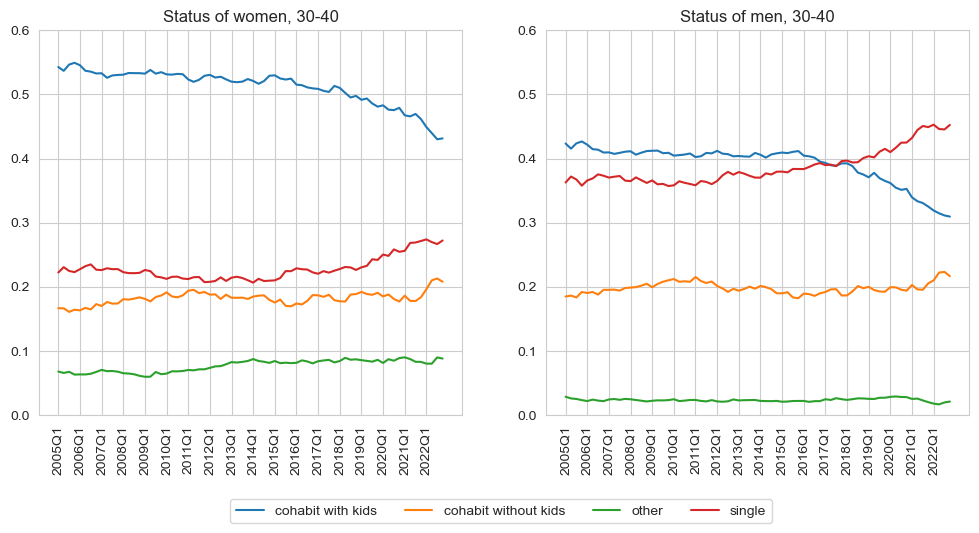

In [75]:
status_list = ["couple_k","couple_0k","other","single"]
labels = ["cohabit with kids","cohabit without kids","other","single"]

plt.figure(figsize=(12,5))
plt.subplot(121)
for i,s in enumerate(status_list): 
    plt.plot(stocks_not_mothers['dates'],stocks_not_mothers[s],label=labels[i])
plt.xticks(stocks_not_mothers['dates'][::4],rotation=90)
plt.legend(bbox_to_anchor=(1.75,-0.2),ncols=4)
plt.ylim(0,0.6)
plt.title('Status of women, 30-40')

plt.subplot(122)
for i,s in enumerate(status_list): 
    plt.plot(stocks_not_fathers['dates'],stocks_not_fathers[s],label=labels[i])
plt.xticks(stocks_not_fathers['dates'][::4],rotation=90)
# plt.legend()
plt.ylim(0,0.6)
plt.title('Status of men, 30-40')
plt.show()